In [2]:
from warnings import filterwarnings

filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

from quant_invest_lab.portfolio import MonteCarloPortfolio, ConvexPortfolio, RiskParityPortfolio
from quant_invest_lab.utils import get_cac40_symbols
from quant_invest_lab.data_provider import build_multi_crypto_dataframe, download_crypto_historical_data

In [16]:
MININUM_HISTORY_YEAR = 1
N = 365
# get_list_of_symbols()
symbols = set(
    [
        "OAS-USDT", "NEO-BTC", "KNC-USDT", "LYM-USDT", "NIM-ETH",
        "TON-USDT", "CFX-ETH", "WAX-BTC", "DOGE-USDC", "CWAR-USDT", "ICPUP-USDT", "AAVE-USDT", "EWT-KCS",
        "ROSE-USDT",
        "AVAX-USDT",
        "UNI-USDT",
        "ATOM-USDT",
        "ICP-USDT",
        "THETA-USDT",
        "VET-USDT",
        "DOGE3S-USDT",
        "BNB-USDT",
        "NEAR-BTC",
        "BTC-USDT",
        "NEAR-USDT",
        "SOLVE-BTC",
        "ETH-USDT",
        "KDA-USDT",
        "SOL-USDT",
        "EGLD-USDT",
        "ALGO-USDT",
        "FTM-USDT",
        "AXS-USDT",
        "ADA-USDT",
        "NKN-USDT",
        "LOOM-BTC",
        "CUSD-USDT",
        "LTC3L-USDT",
        "XPR-USDT",
    ]
)


closes = build_multi_crypto_dataframe(symbols)

cols_to_remove = [
    col
    for col, nans in closes.isna().sum().items()
    if len(closes) - nans < int(N * MININUM_HISTORY_YEAR)
]


closes.drop(columns=cols_to_remove, inplace=True)
returns = closes.pct_change().dropna()
log_returns = np.log(closes).pct_change().dropna()
returns.head()

Fetching symbols...: 100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


,EGLD-USDT_Close,ALGO-USDT_Close,NEAR-BTC_Close,SOL-USDT_Close,XPR-USDT_Close,CUSD-USDT_Close,ROSE-USDT_Close,SOLVE-BTC_Close,VET-USDT_Close,ADA-USDT_Close,...,ATOM-USDT_Close,LOOM-BTC_Close,AVAX-USDT_Close,NEAR-USDT_Close,ICP-USDT_Close,DOGE3S-USDT_Close,UNI-USDT_Close,NIM-ETH_Close,FTM-USDT_Close,DOGE-USDC_Close
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-27,0.032981,0.023018,-0.015302,0.027243,0.007009,-0.000703,0.035946,-0.021390,0.016228,0.017323,...,0.056240,-0.014354,0.016738,0.014153,0.019320,-0.051186,0.028275,0.043956,0.019039,0.016124
2022-04-28,-0.017501,0.041276,-0.047227,-0.001464,-0.048724,-0.002815,-0.022919,0.000000,-0.008082,0.003422,...,-0.032528,-0.009709,-0.036733,-0.036717,-0.011111,0.055353,-0.007218,-0.084211,-0.017661,-0.017227
2022-04-29,-0.084982,-0.087006,-0.064279,-0.043550,0.012195,0.003125,-0.078314,0.010929,-0.059766,-0.045163,...,-0.062882,-0.014706,-0.057959,-0.089632,-0.064772,0.055296,-0.067415,-0.011494,-0.140211,-0.017965
2022-04-30,-0.053496,-0.110815,-0.061517,-0.099369,0.010843,0.001206,-0.156401,0.005405,-0.065494,-0.061571,...,-0.082474,-0.029851,-0.101390,-0.083995,-0.123675,0.169307,-0.113511,-0.011628,-0.179421,-0.057621
2022-05-01,0.000392,0.060286,0.119811,0.060650,-0.026222,-0.001907,0.067668,-0.016129,0.070097,0.045557,...,0.008711,-0.010256,0.031951,0.144173,0.052419,-0.129135,0.053993,-0.035294,0.148863,0.044797


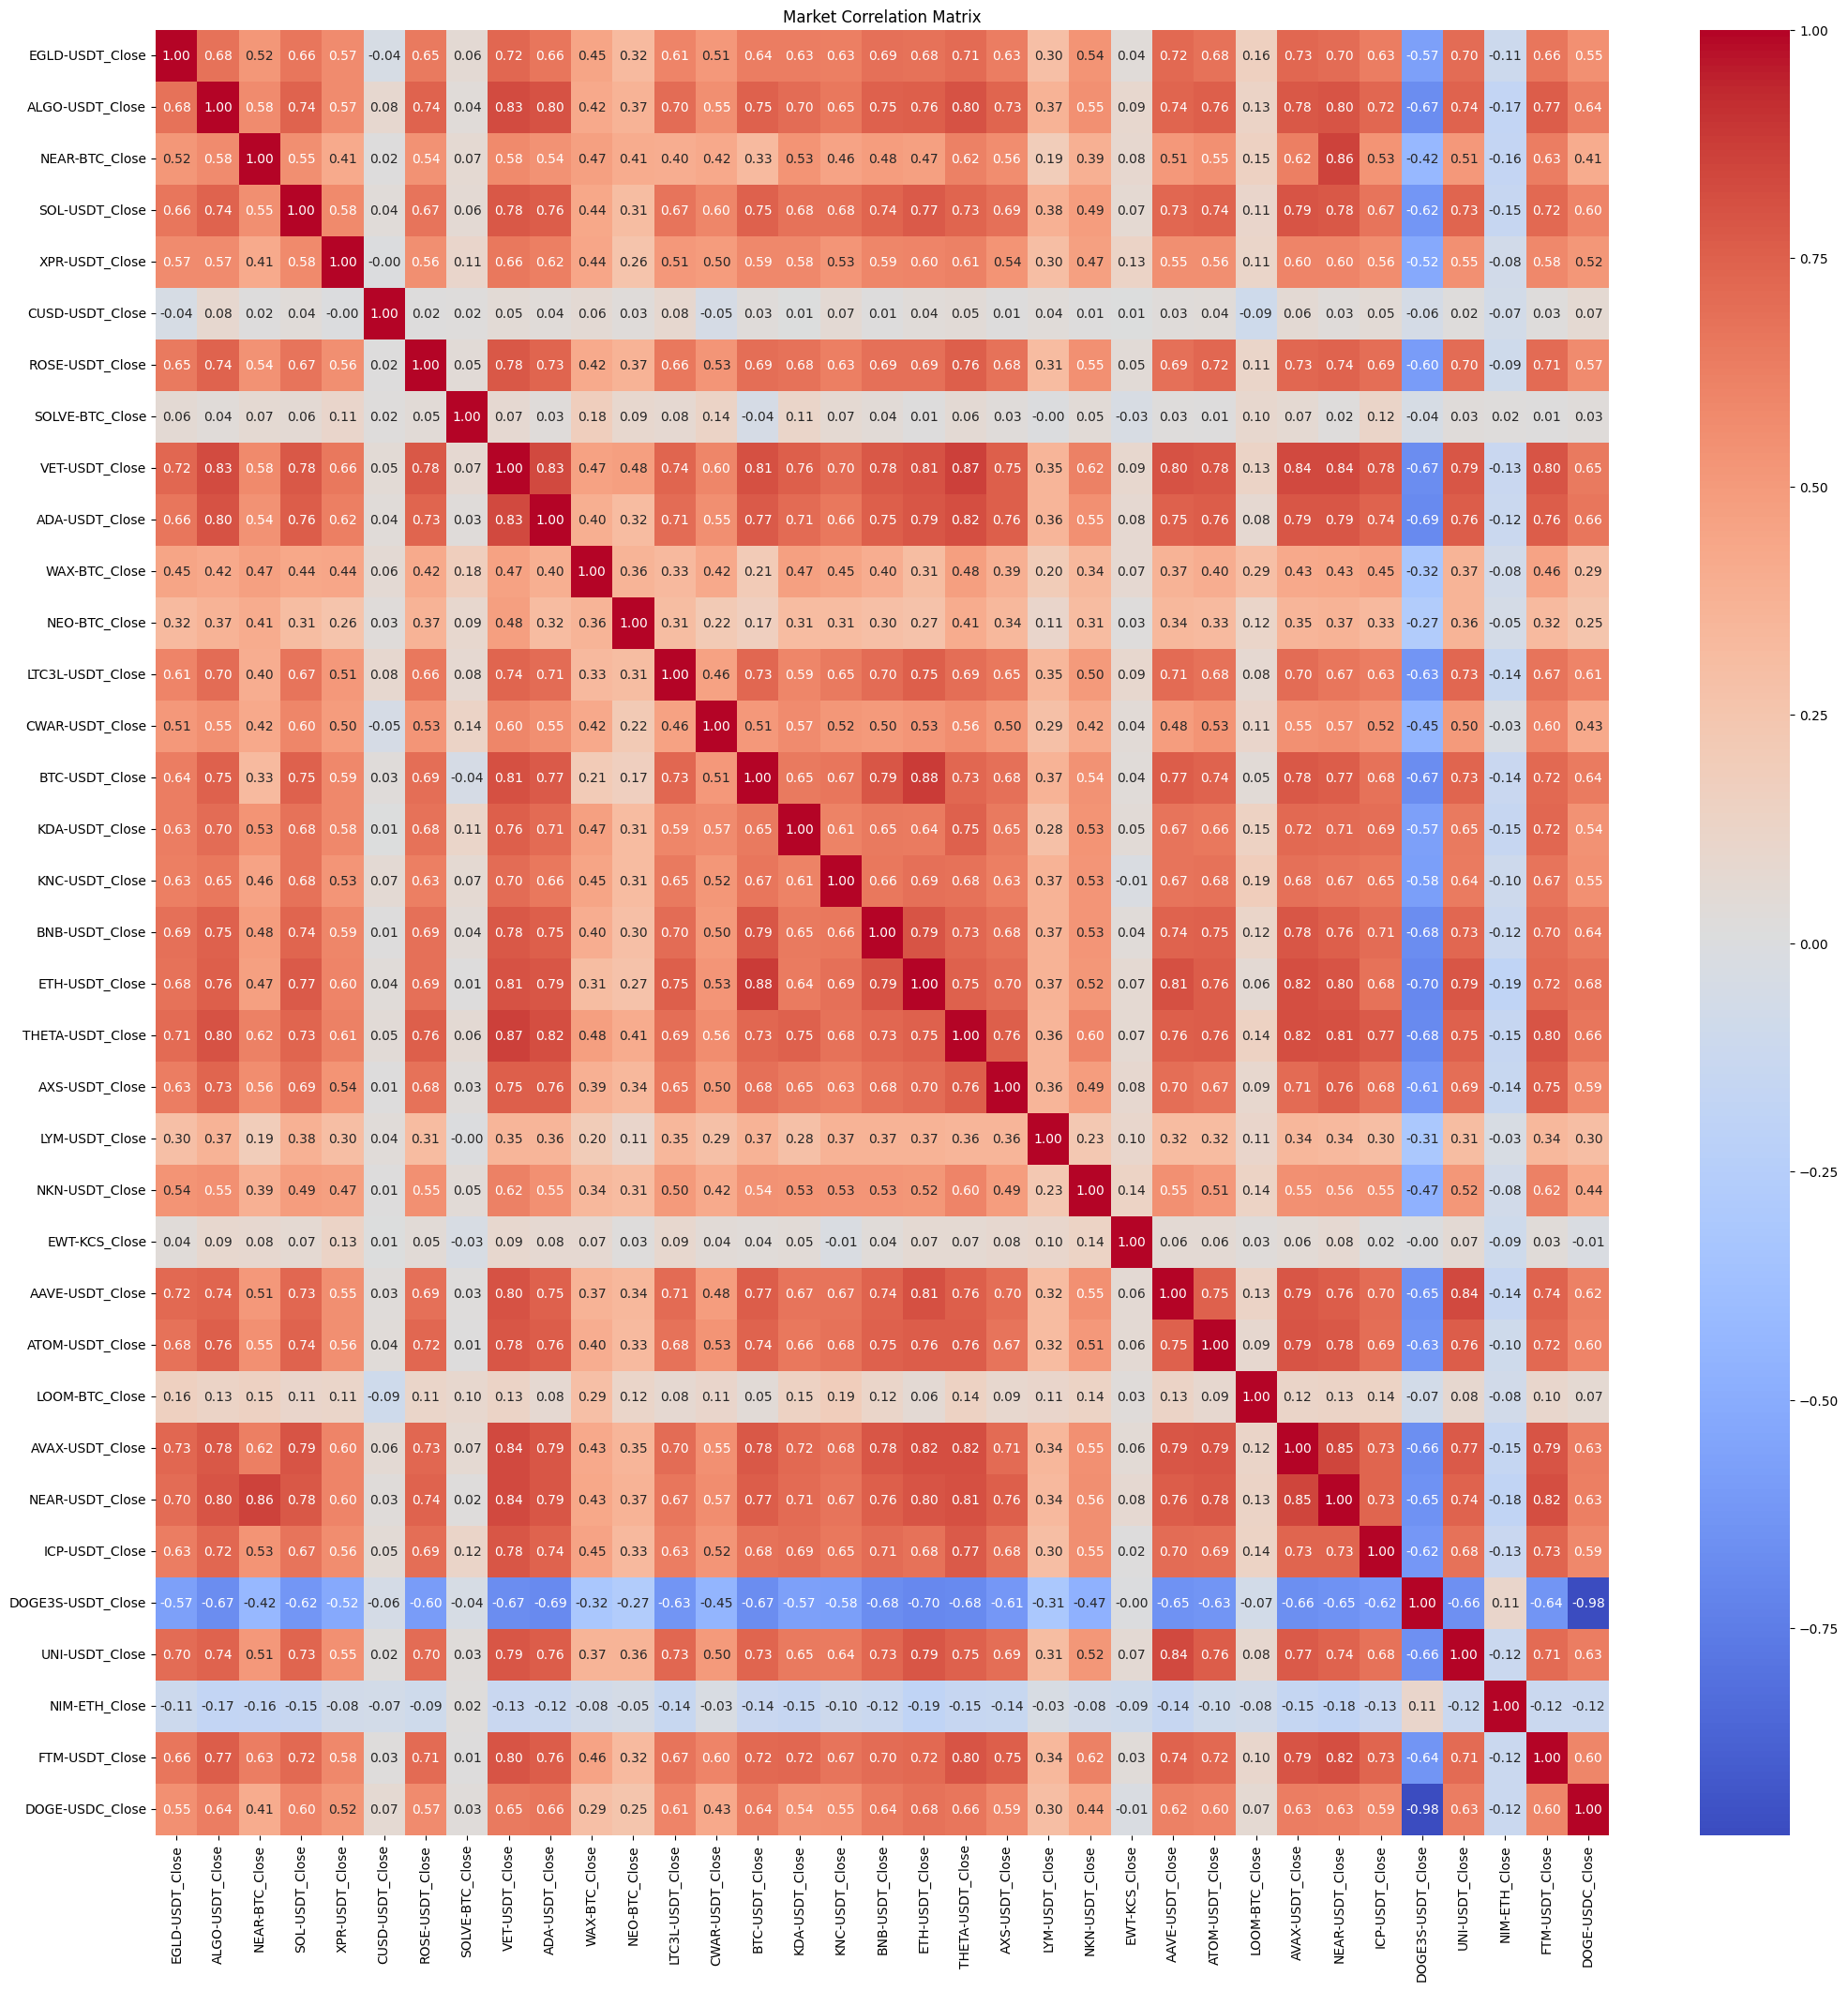

In [17]:
import seaborn as sns

plt.figure(figsize=(25, 25))  # Optional: adjust the figure size

# Choose a color map of your preference (e.g., 'viridis', 'coolwarm', 'RdYlBu_r', etc.)
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Market Correlation Matrix')
plt.show()

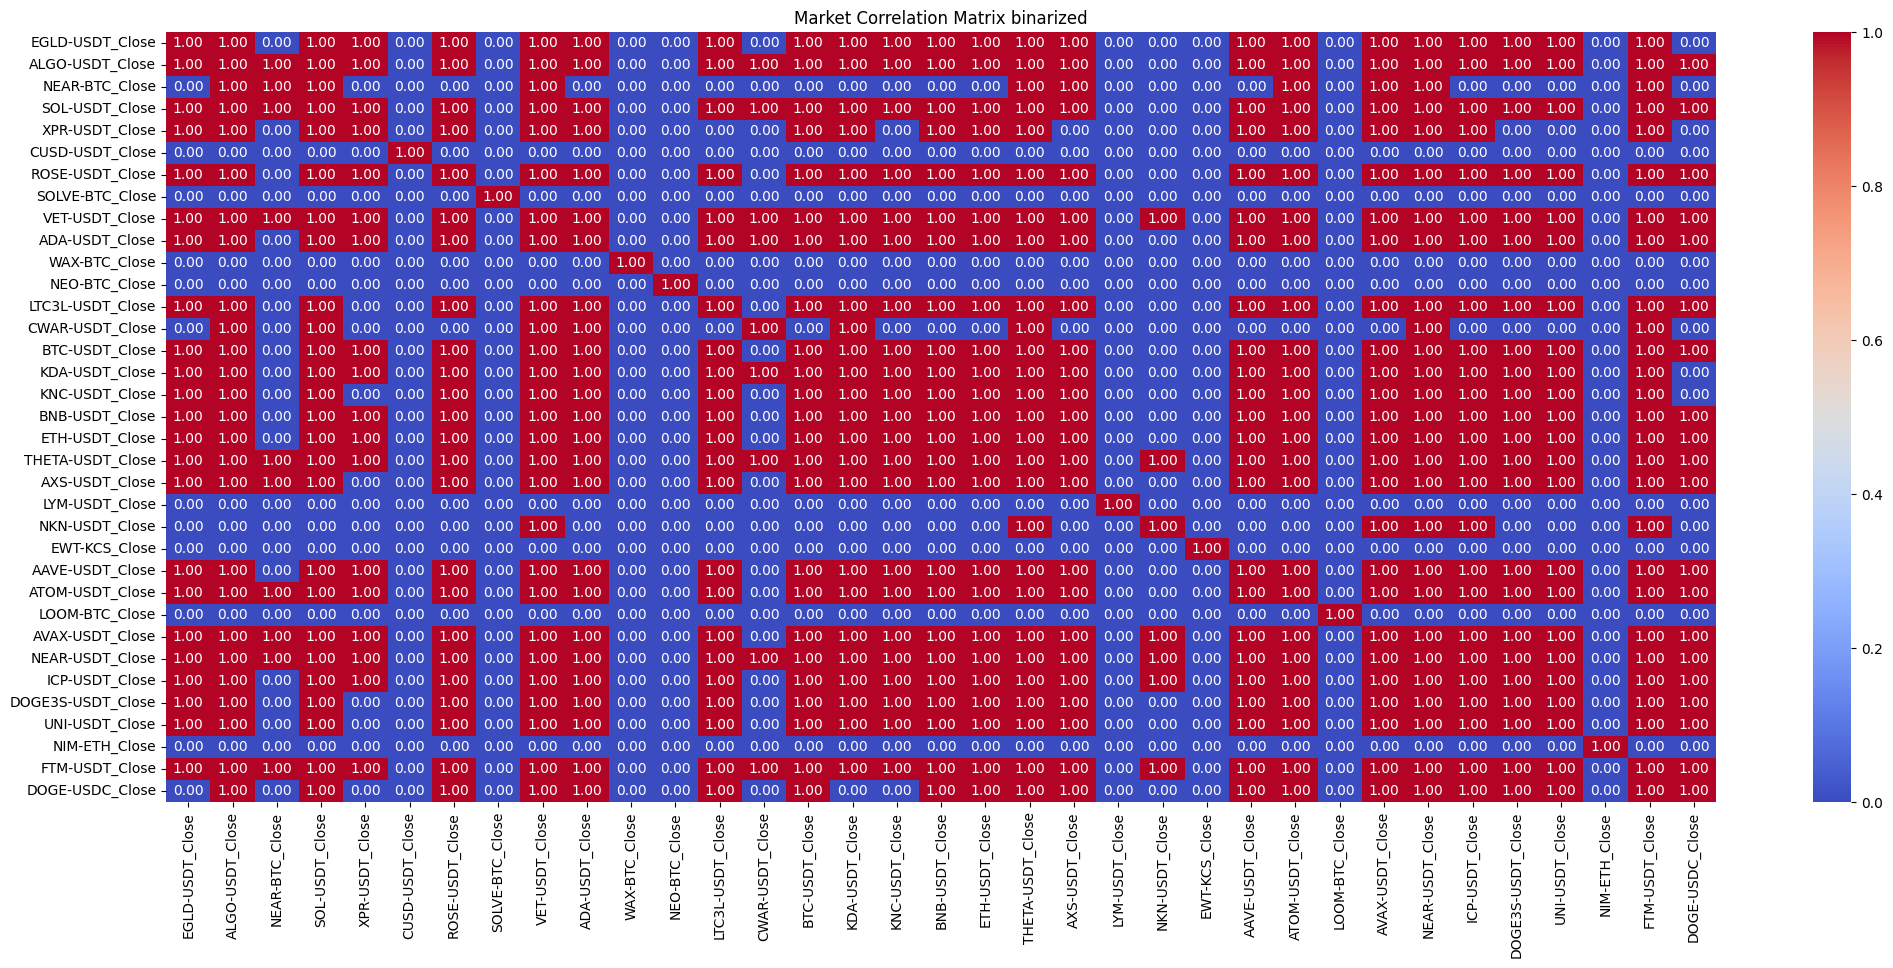

In [18]:
binarized_corr = (returns.corr().abs()>0.55).astype(int)
plt.figure(figsize=(25, 10))  # Optional: adjust the figure size

# Choose a color map of your preference (e.g., 'viridis', 'coolwarm', 'RdYlBu_r', etc.)
sns.heatmap(binarized_corr, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Market Correlation Matrix binarized')
plt.show()

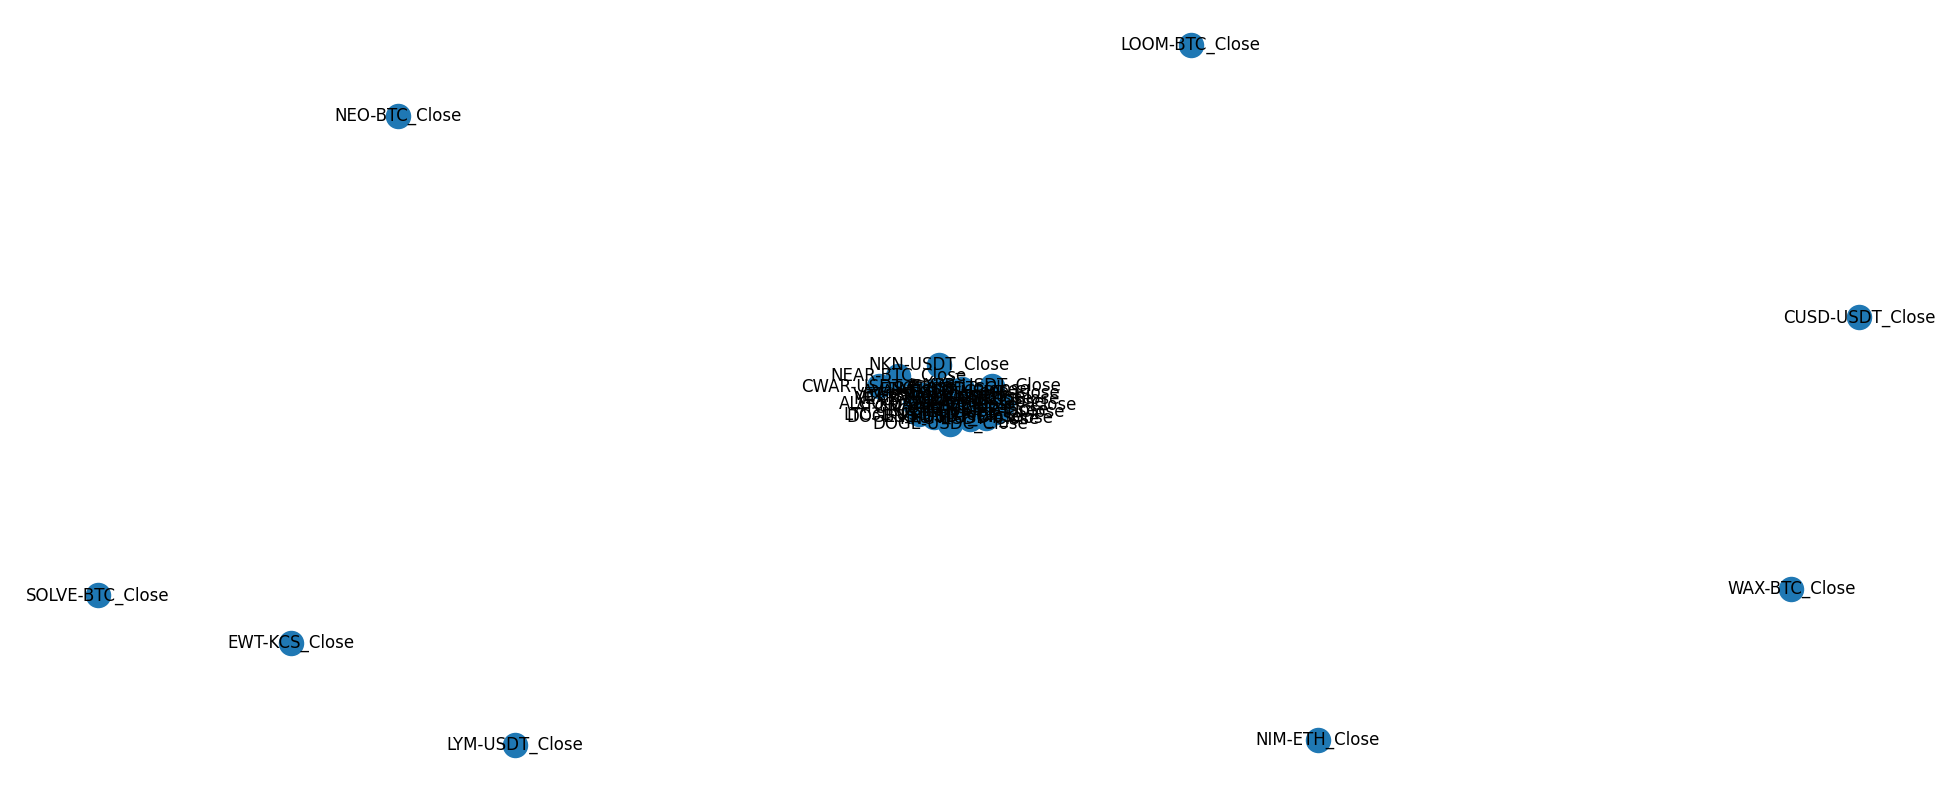

[('VET-USDT_Close', 26),
 ('THETA-USDT_Close', 26),
 ('NEAR-USDT_Close', 26),
 ('FTM-USDT_Close', 26),
 ('ALGO-USDT_Close', 25),
 ('SOL-USDT_Close', 25),
 ('AVAX-USDT_Close', 25),
 ('ADA-USDT_Close', 24),
 ('ATOM-USDT_Close', 24),
 ('ICP-USDT_Close', 24),
 ('ROSE-USDT_Close', 23),
 ('BTC-USDT_Close', 23),
 ('KDA-USDT_Close', 23),
 ('BNB-USDT_Close', 23),
 ('ETH-USDT_Close', 23),
 ('AXS-USDT_Close', 23),
 ('AAVE-USDT_Close', 23),
 ('EGLD-USDT_Close', 22),
 ('LTC3L-USDT_Close', 22),
 ('DOGE3S-USDT_Close', 22),
 ('UNI-USDT_Close', 22),
 ('KNC-USDT_Close', 21),
 ('DOGE-USDC_Close', 19),
 ('XPR-USDT_Close', 17),
 ('NEAR-BTC_Close', 9),
 ('CWAR-USDT_Close', 8),
 ('NKN-USDT_Close', 6),
 ('CUSD-USDT_Close', 0),
 ('SOLVE-BTC_Close', 0),
 ('WAX-BTC_Close', 0),
 ('NEO-BTC_Close', 0),
 ('LYM-USDT_Close', 0),
 ('EWT-KCS_Close', 0),
 ('LOOM-BTC_Close', 0),
 ('NIM-ETH_Close', 0)]

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1,figsize=(25, 10))

np.fill_diagonal(binarized_corr.values, 0)
# Create a graph from the adjacency matrix

graph = nx.from_pandas_adjacency(binarized_corr)

nx.draw(graph, with_labels=True)

plt.show()

degrees = tuple(graph.degree)
degrees_sorted = sorted(degrees, key=lambda company: company[-1],reverse=True)
degrees_sorted
